Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
+----+-------------------+----------------------------------------------+---------+---------+---------+----------+
|    | Model             | Best Params                                  |     MAE |     MSE |    RMSE |       R2 |
|----+-------------------+----------------------------------------------+---------+---------+---------+----------|
|  0 | Random Forest     | {'n_estimators': 300}                        | 6.38281 | 61.4509 | 7.83736 | 0.258062 |
|  1 | Gradient Boosting | {'learning_rate': 0.1, 'n_estimators': 200}  | 6.35171 | 61.0681 | 7.81325 | 0.262695 |
|  2 | CatBoost          | {'iterations': 200, 'learning_rate': 0.1}    | 6.31338 | 60.5283 | 7.77849 | 0.269256 |
|  3 | XGBoost           | {'learning_rate': 0.05, 'n_estimators':

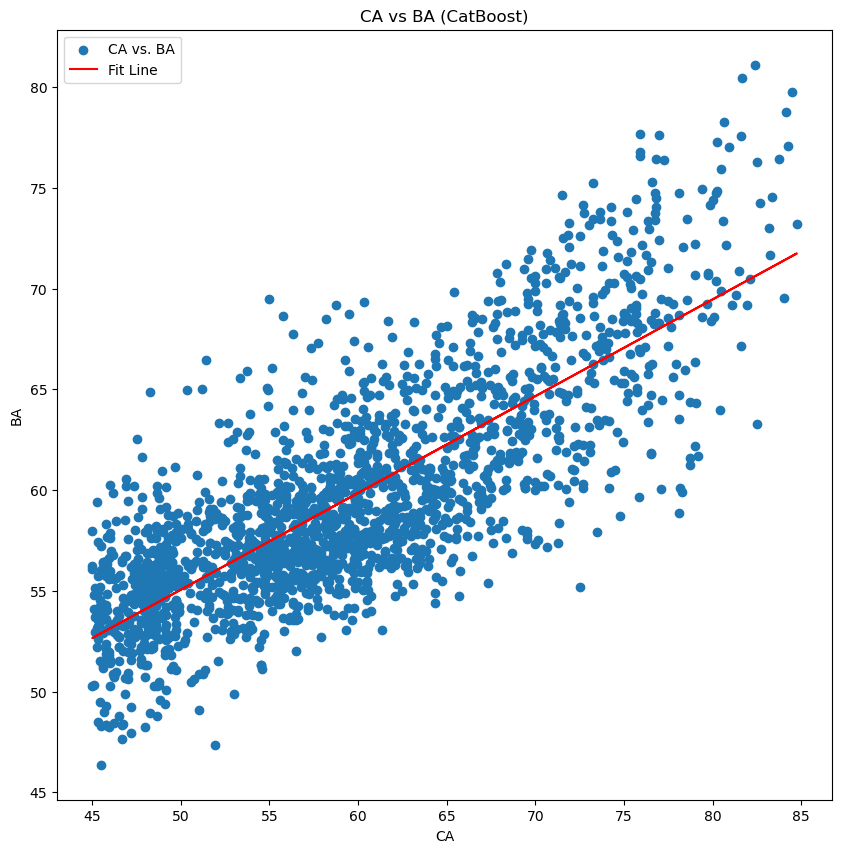

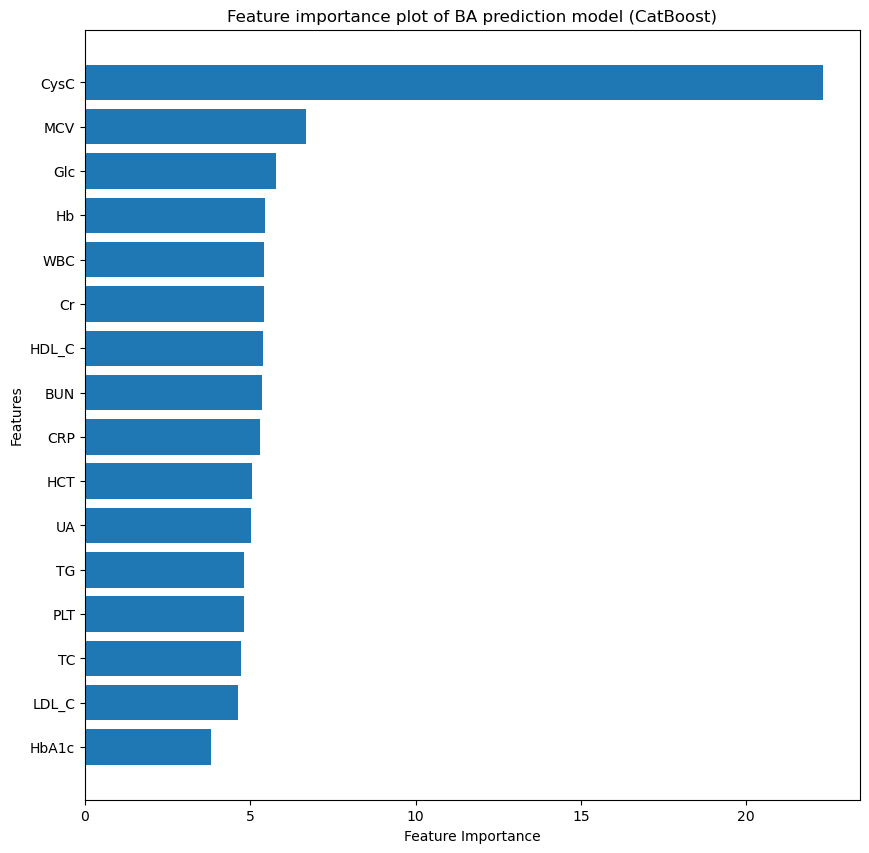

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load data
data = pd.read_csv('data2011.csv')
target = 'ca'
features = ['WBC', 'MCV', 'PLT', 'BUN', 'Glc', 'Cr', 'TC', 'TG', 'HDL_C', 'LDL_C', 'CRP', 'HbA1c', 'UA', 'HCT', 'Hb', 'CysC']

sampled_data = data.sample(frac=1, random_state=42)
X1 = sampled_data[features]
y = sampled_data[target]

scaler = MinMaxScaler()
X = scaler.fit_transform(X1)

# Define models with initial parameters
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(silent=True, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Define hyperparameters grid for Grid Search
param_grids = {
    'Random Forest': {'n_estimators': [100, 200, 300]},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.2]},
    'CatBoost': {'iterations': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.2]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.2]}
}

# Perform hyperparameter tuning using Grid Search
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=1)
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    mae_scores = -cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mse_scores = -cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    r2_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')

    results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'MAE': mae_scores.mean(),
        'MSE': mse_scores.mean(),
        'RMSE': rmse_scores.mean(),
        'R2': r2_scores.mean()
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(tabulate(results_df, headers='keys', tablefmt='psql'))

# Select the best model based on MAE
best_model_row = results_df.loc[results_df['MAE'].idxmin()]
best_model_name = best_model_row['Model']
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Model Parameters: {best_model_row['Best Params']}")

# Train the best model on full data
best_model.fit(X, y)

# External validation
external_data = pd.read_csv('data2015.csv')
X1_ext = external_data[features]
y_ext = external_data[target]

# Preprocess the external dataset
X_ext = scaler.transform(X1_ext)

# Predict and evaluate on the external dataset
y_ext_pred = best_model.predict(X_ext)

mae_ext = np.mean(np.abs(y_ext - y_ext_pred))
mse_ext = np.mean((y_ext - y_ext_pred)**2)
rmse_ext = np.sqrt(mse_ext)
r2_ext = best_model.score(X_ext, y_ext)

print(f"External Validation Results - {best_model_name}:")
print(f"MAE: {mae_ext}")
print(f"MSE: {mse_ext}")
print(f"RMSE: {rmse_ext}")
print(f"R2: {r2_ext}")

# Scatter plot of actual vs predicted for the best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=1, label='CA vs. BA')

# Fit a linear regression line (correlation line)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Fit Line')

plt.xlabel('CA')
plt.ylabel('BA')
plt.title(f'CA vs BA ({best_model_name})')
plt.legend()
plt.show()

# Plot feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    features_sorted = np.array(features)[sorted_idx]

    plt.figure(figsize=(10, 10))
    plt.barh(range(len(features_sorted)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(features_sorted)), features_sorted)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Feature importance plot of BA prediction model ({best_model_name})')
    plt.show()


In [ ]:
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")